-------------------------------------------------------------

**If any part of this notebook is used in your research, please cite with the reference found in [README.md](https://github.com/jGaboardi/tigernet#citations)**.

-------------------------------------------------------------

# Example usage: empirical network


### Author: James D. Gaboardi jgaboardi@gmail.com


-------------------------------------------------------------

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2021-07-08T10:03:22.229630-04:00

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.25.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import tigernet
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.2.0

json    : 2.0.9
tigernet: 0.2.4



------------------------------------
## Read in TIGER/Line Edge data
### Subset of Leon County, FL from 2010

In [3]:
gdf = tigernet.testing_data("Edges_Leon_FL_2010", direc="../test_data")
gdf.head()

,STATEFP,COUNTYFP,TLID,TFIDL,TFIDR,MTFCC,FULLNAME,SMID,LFROMADD,LTOADD,...,TTYP,DECKEDROAD,ARTPATH,PERSIST,GCSEFLG,OFFSETL,OFFSETR,TNIDF,TNIDT,geometry
0,12,073,82901885,201693593,201688681,P0002,None,533,None,None,...,None,None,None,None,N,N,N,93201005,93201005,"LINESTRING (622786.161 163956.705, 622778.573 ..."
1,12,073,82902003,201693007,201688795,P0002,None,533,None,None,...,None,None,None,None,N,N,N,93201256,93201256,"LINESTRING (622462.418 166562.397, 622466.165 ..."
2,12,073,82902005,201693220,201688867,P0002,None,533,None,None,...,None,None,None,None,N,N,N,93201260,93201260,"LINESTRING (623233.871 166132.321, 623241.929 ..."
3,12,073,82902019,250083176,201688881,P0002,None,533,None,None,...,None,None,None,None,N,N,N,93201290,93201290,"LINESTRING (624266.355 165294.262, 624268.365 ..."
4,12,073,82852900,201692756,201693174,S1400,Adwood Dr,533,3200,3298,...,None,N,N,None,N,N,N,93183015,93183016,"LINESTRING (623053.529 165294.971, 623053.678 ..."


### Extract only the road edges

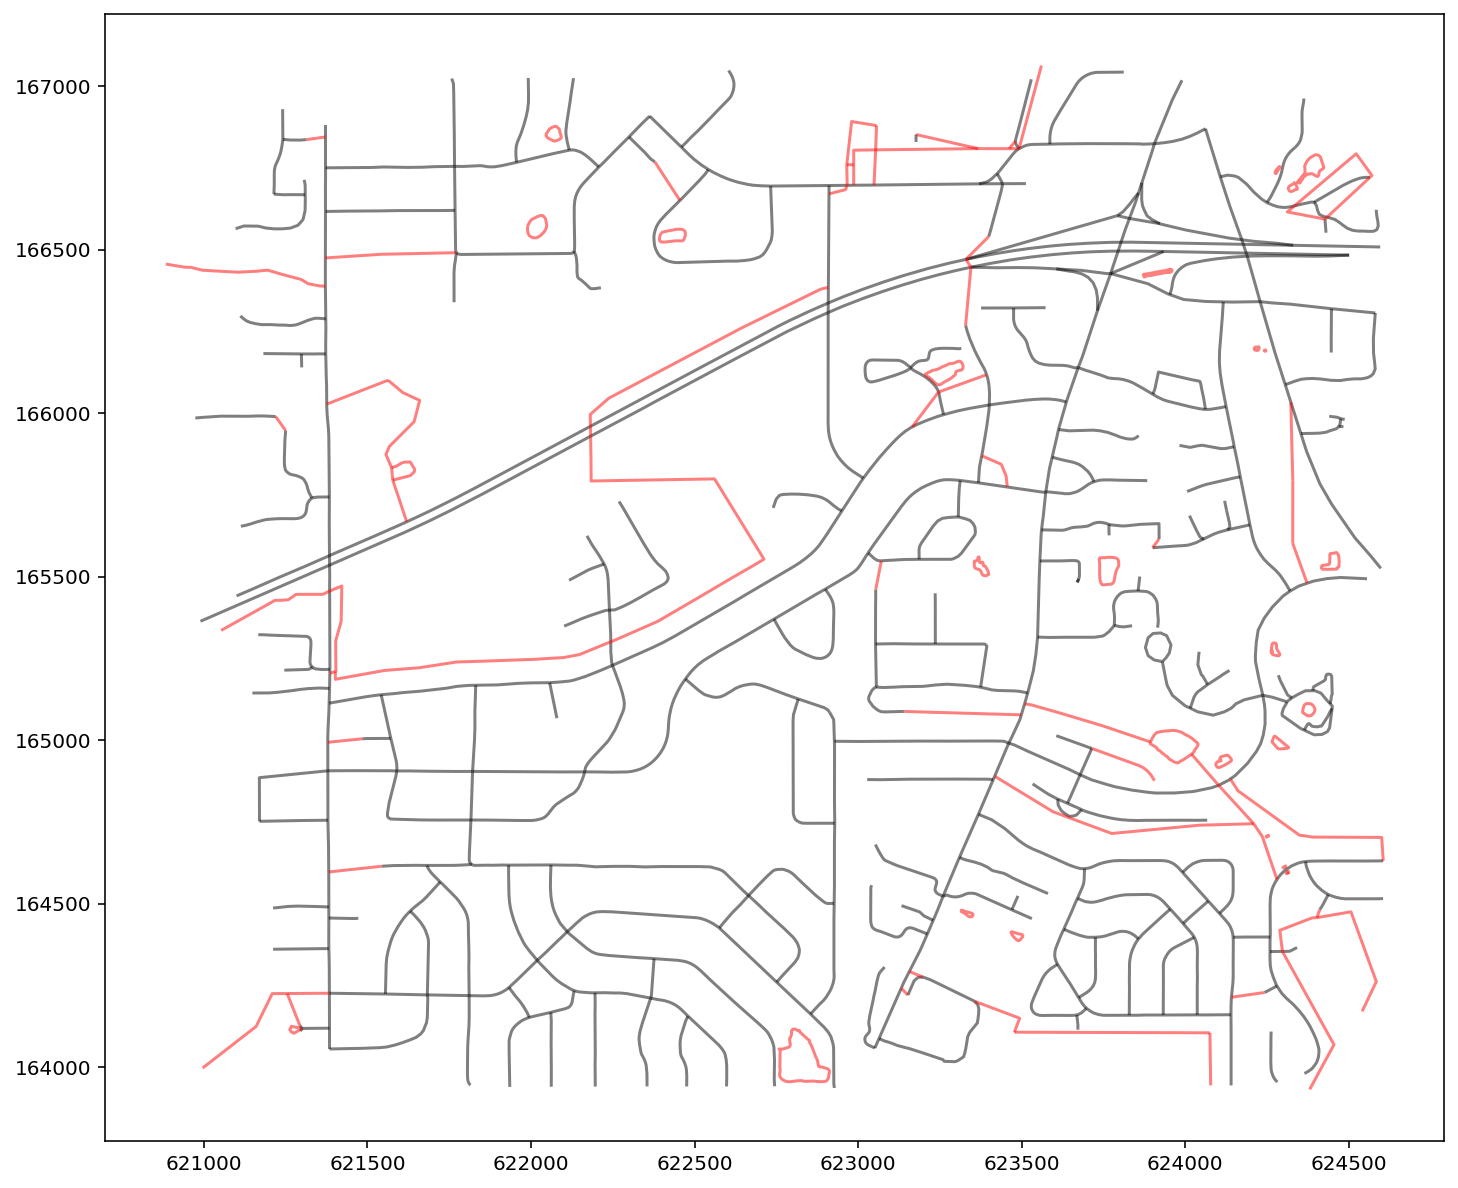

In [4]:
yes_roads = gdf["MTFCC"].str.startswith("S")
no_roads = ~gdf["MTFCC"].str.startswith("S")
ax = gdf[yes_roads].plot(figsize=(12,12), color="k", alpha=.5, zorder=0)
gdf[no_roads].plot(ax=ax, color="r", alpha=.5, zorder=1)
roads = gdf[yes_roads].copy()

-------------------------
## Set network creation parameters

In [5]:
# Tiger attributes primary and secondary
ATTR1, ATTR2 = "MTFCC", "TLID"                                 
# segment welding and splitting
INTRST = "S1100"                        # interstates mtfcc code
RAMP =  "S1630"                         # ramp mtfcc code
SERV_DR = "S1640"                       # service drive mtfcc code
SPLIT_GRP = "FULLNAME"                  # grouped by this variable
SPLIT_BY = [RAMP, SERV_DR]              # split interstates by ramps & service
SKIP_RESTR = True                       # no weld retry if still MLS
kwargs = {"s_data": roads.copy(), "from_raw": True}
attr_kws = {"attr1": ATTR1, "attr2": ATTR2}
kwargs.update(attr_kws)
comp_kws = {"record_components": True, "largest_component":True} 
kwargs.update(comp_kws)
geom_kws = {"record_geom": True, "calc_len": True}
kwargs.update(geom_kws)
mtfcc_kws = {"discard_segs": None, "skip_restr": SKIP_RESTR}
mtfcc_kws.update({"mtfcc_split": INTRST, "mtfcc_intrst": INTRST})
mtfcc_kws.update({"mtfcc_split_grp": SPLIT_GRP, "mtfcc_ramp": RAMP})
mtfcc_kws.update({"mtfcc_split_by": SPLIT_BY, "mtfcc_serv": SERV_DR})
kwargs.update(mtfcc_kws)

## Generate the network
* retain only the largest segment
* simplify
* calculate the network matrix

In [6]:
network = tigernet.Network(**kwargs)
network.simplify_network(
    inplace=True,
    record_components=True,
    record_geom=True,
    largest_component=False,
    def_graph_elems=True
)
network.cost_matrix(asattr=True)

In [7]:
skws = {"color": "k", "alpha": .5, "zorder": 0}
nkws = {"color": "r", "markersize": 70, "alpha": .5, "ec":"k", "zorder": 1}

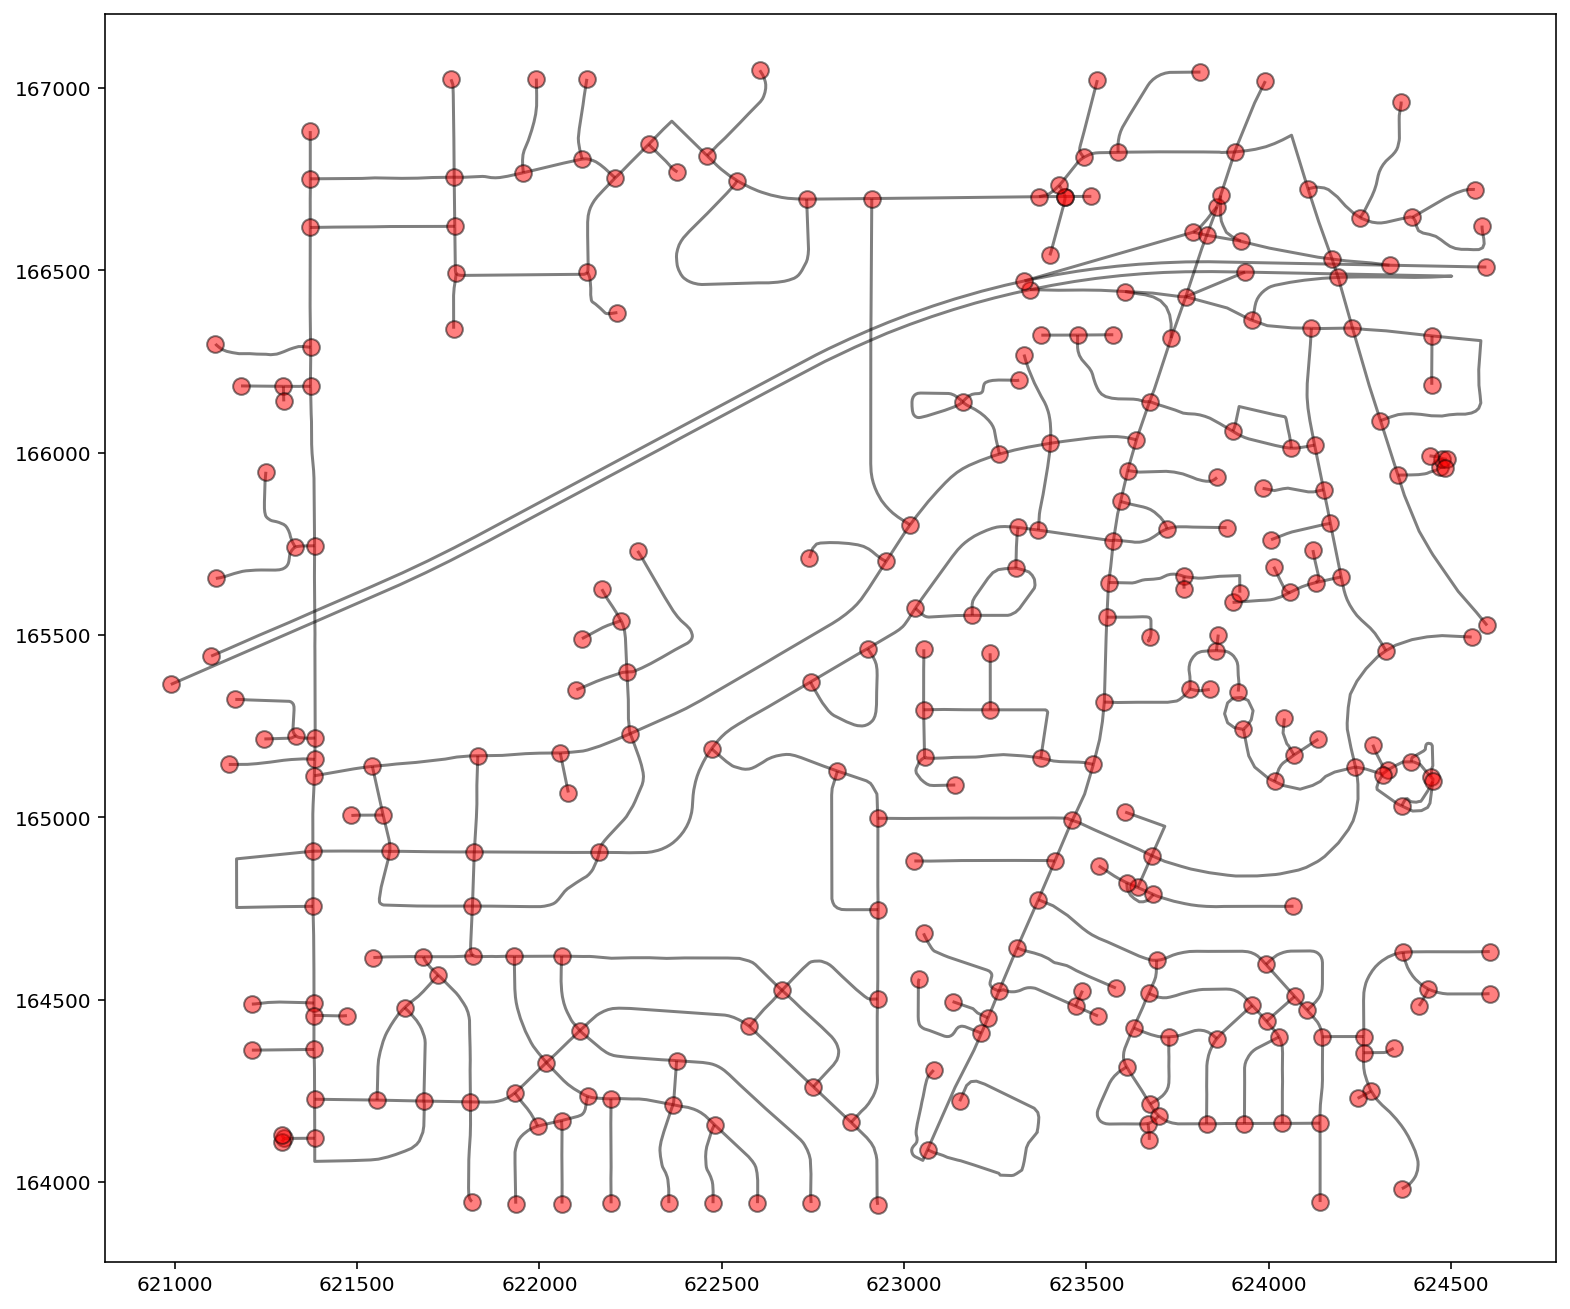

In [8]:
ax = network.s_data.plot(figsize=(13,13), **skws)
network.n_data.plot(ax=ax, **nkws);

------------------------------------
## Read in populated empirical observations data from 2010
* Subset of population-weighted parcel data (see [`References`](https://github.com/jGaboardi/tigernet#references))
* Subset of Census block centroids

In [9]:
parcels = tigernet.testing_data(
    "WeightedParcels_Leon_FL_2010", direc="../test_data"
)
parcels = parcels[parcels["SUM_EST_PO"] > 0]
parcels.reset_index(inplace=True, drop=True)
parcels.head()

,PARCEL_ID,DOR_UC,PA_UC,JV_HMSTD,JV_NON_HMS,JV_RESD_NO,LND_SQFOOT,EFF_YR_BLT,ACT_YR_BLT,TOT_LVG_AR,NO_BULDNG,NO_RES_UNT,CENSUS_BK,OBJECTID,PARCEL_ID_,FREQUENCY,SUM_EST_PO,geometry
0,110860 A0090,001,00,194118.0,0.0,0.0,0.0,1965.0,1965.0,2563.0,1.0,1.0,120730017001,5223,110860 A0090,1,2.258065,POINT (623335.510 165547.744)
1,110710 H0060,001,00,0.0,256932.0,0.0,41382.0,1975.0,1975.0,3225.0,1.0,1.0,120730024073,4698,110710 H0060,1,2.425000,POINT (621724.357 166581.676)
2,110710 G0051,001,00,194952.0,0.0,0.0,30492.0,1990.0,1990.0,1917.0,1.0,1.0,120730024073,4690,110710 G0051,1,2.425000,POINT (622254.299 166392.348)
3,1108910000150,001,00,187202.0,0.0,0.0,0.0,1990.0,1990.0,2284.0,1.0,1.0,120730017002,5362,1108910000150,1,1.564428,POINT (623883.984 165682.548)
4,1108910000290,001,00,182921.0,0.0,0.0,0.0,1990.0,1990.0,2395.0,1.0,1.0,120730017002,5376,1108910000290,1,1.564428,POINT (623903.888 165653.490)


In [10]:
blocks = tigernet.testing_data(
    "CensusBlocks_Leon_FL_2010", direc="../test_data"
)
blocks = blocks[blocks["POP100"] > 0]
blocks.reset_index(inplace=True, drop=True)
blocks.head()

,AREALAND,AREAWATER,BASENAME,BLKGRP,BLOCK,CENTLAT,CENTLON,COUNTY,FUNCSTAT,GEOID,...,NAME,OBJECTID,OID,POP100,STATE,STGEOMETRY,STGEOMET_1,TRACT,UR,geometry
0,19445,0,1023,1,1023,+30.4879178,-084.2762366,073,S,120730017001023,...,Block 1023,2254893,2147483647,14,12,26271.009750,688.668883,001700,U,POINT (621482.913 164954.611)
1,88674,0,6006,6,6006,+30.4833298,-084.2760021,073,S,120730017006006,...,Block 6006,2254894,2147483647,52,12,119791.244382,1523.888963,001700,U,POINT (621506.423 164446.042)
2,30907,0,3009,3,3009,+30.4834540,-084.2522277,073,S,120730017003009,...,Block 3009,3060699,2147483647,34,12,41753.026831,909.873691,001700,U,POINT (623789.018 164464.526)
3,18307,0,3010,3,3010,+30.4822104,-084.2534670,073,S,120730017003010,...,Block 3010,3060702,2147483647,22,12,24731.402941,632.183730,001700,U,POINT (623670.323 164326.412)
4,16010,0,3003,3,3003,+30.4843914,-084.2491360,073,S,120730017003003,...,Block 3003,3060703,2147483647,17,12,21628.938982,579.415736,001700,U,POINT (624085.626 164569.096)


In [11]:
o1kws = {"color": "b", "markersize": 20, "alpha": .75, "ec":"k", "zorder": 2}
o2kws = {"color": "g", "markersize": 60, "alpha": .75, "ec":"k", "zorder": 2}

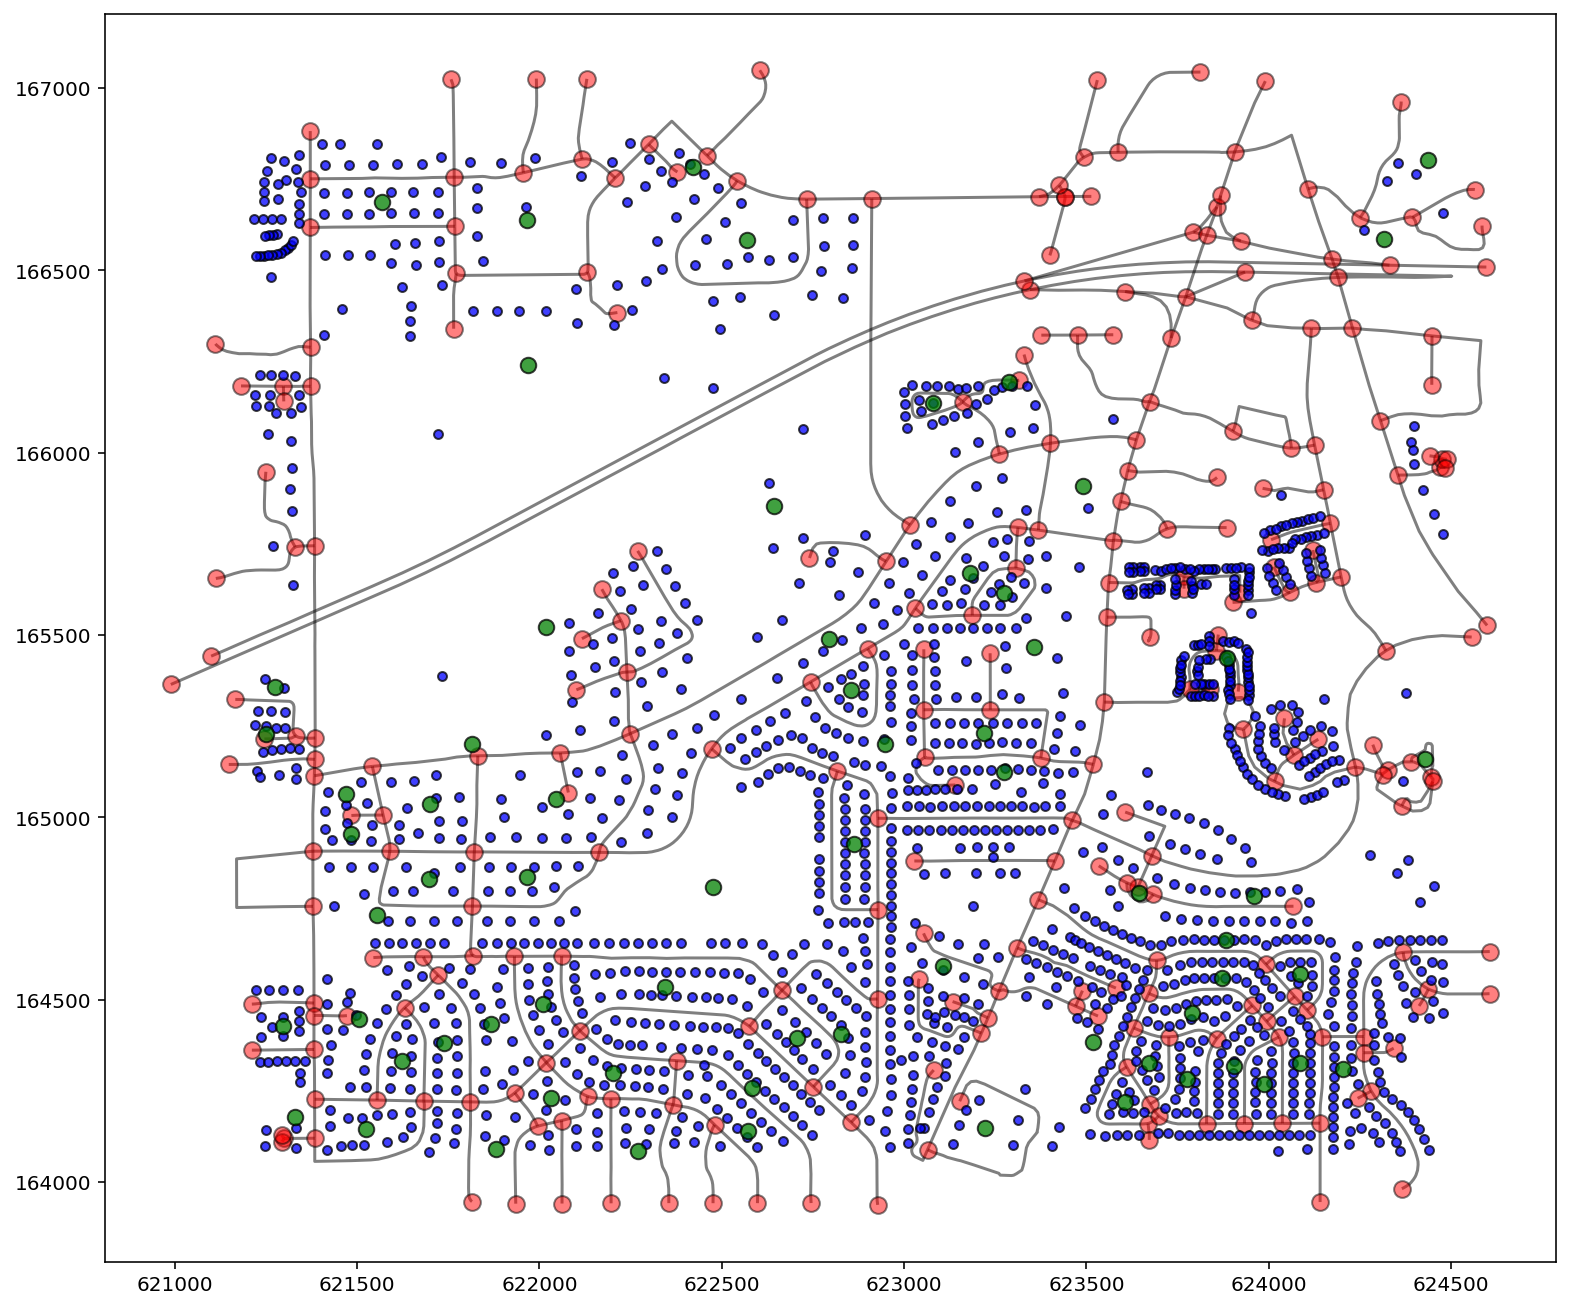

In [12]:
ax = network.s_data.plot(figsize=(13,13), **skws)
network.n_data.plot(ax=ax, **nkws)
parcels.plot(ax=ax, **o1kws)
blocks.plot(ax=ax, **o2kws);

-------------------------------------------------------------
## Associate the parcels & blocks with the network
* Disallow the snapping of observations to major highways and service raods/ramps

In [13]:
SNAP_RESTRICT = [INTRST, RAMP, SERV_DR] # interstates, ramps, service roads
parcels = tigernet.Observations(
    network,
    parcels,
    df_name="obs1",
    df_key="PARCEL_ID",
    restrict_col="MTFCC",
    remove_restricted=SNAP_RESTRICT,
)
blocks = tigernet.Observations(
    network,
    blocks,
    df_name="obs1",
    df_key="GEOID",
    restrict_col="MTFCC",
    remove_restricted=SNAP_RESTRICT,
)

In [14]:
b1kws = {"color": "b", "markersize": 10, "alpha": .95, "ec":"k", "zorder": 3}
b2kws = {"color": "g", "markersize": 40, "alpha": .95, "ec":"k", "zorder": 3}

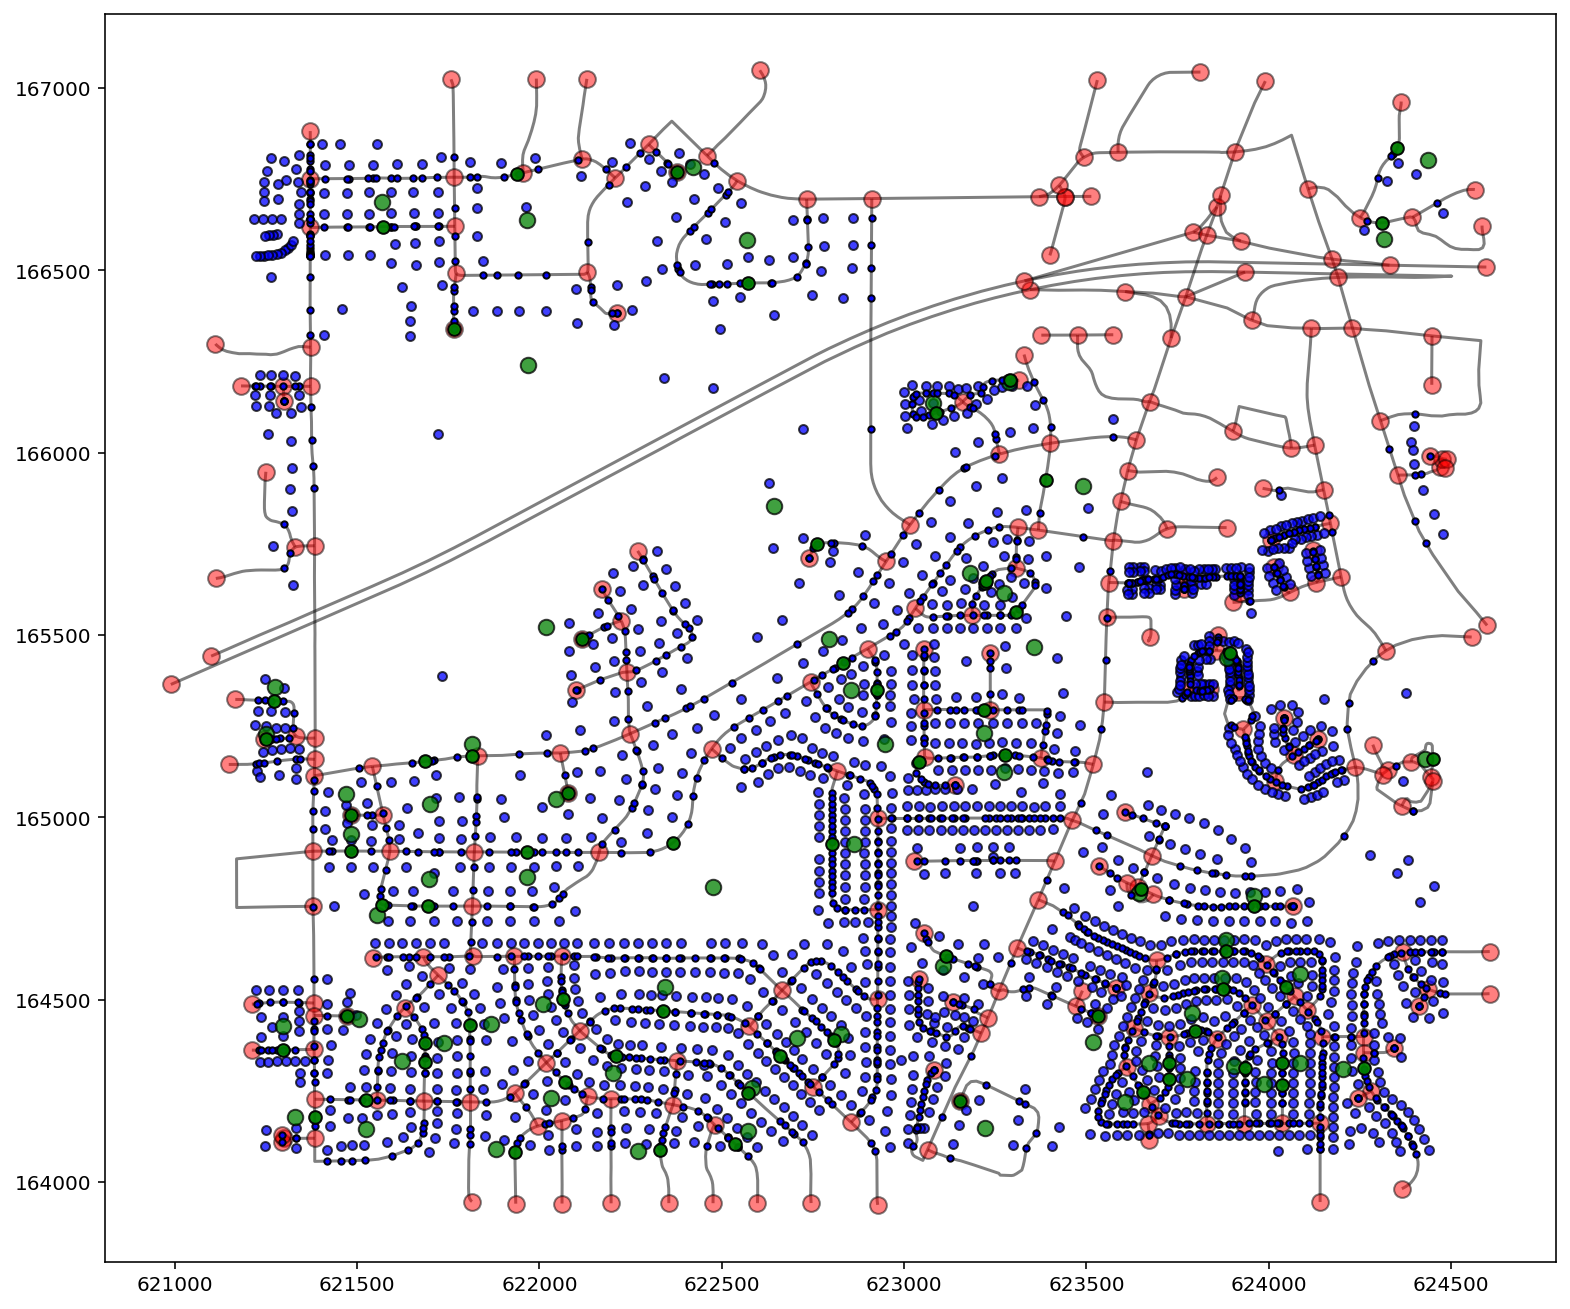

In [15]:
ax = network.s_data.plot(figsize=(13,13), **skws)
network.n_data.plot(ax=ax, **nkws);
parcels.df.plot(ax=ax, **o1kws)
parcels.snapped_points.plot(ax=ax, **b1kws)
blocks.df.plot(ax=ax, **o2kws)
blocks.snapped_points.plot(ax=ax, **b2kws);

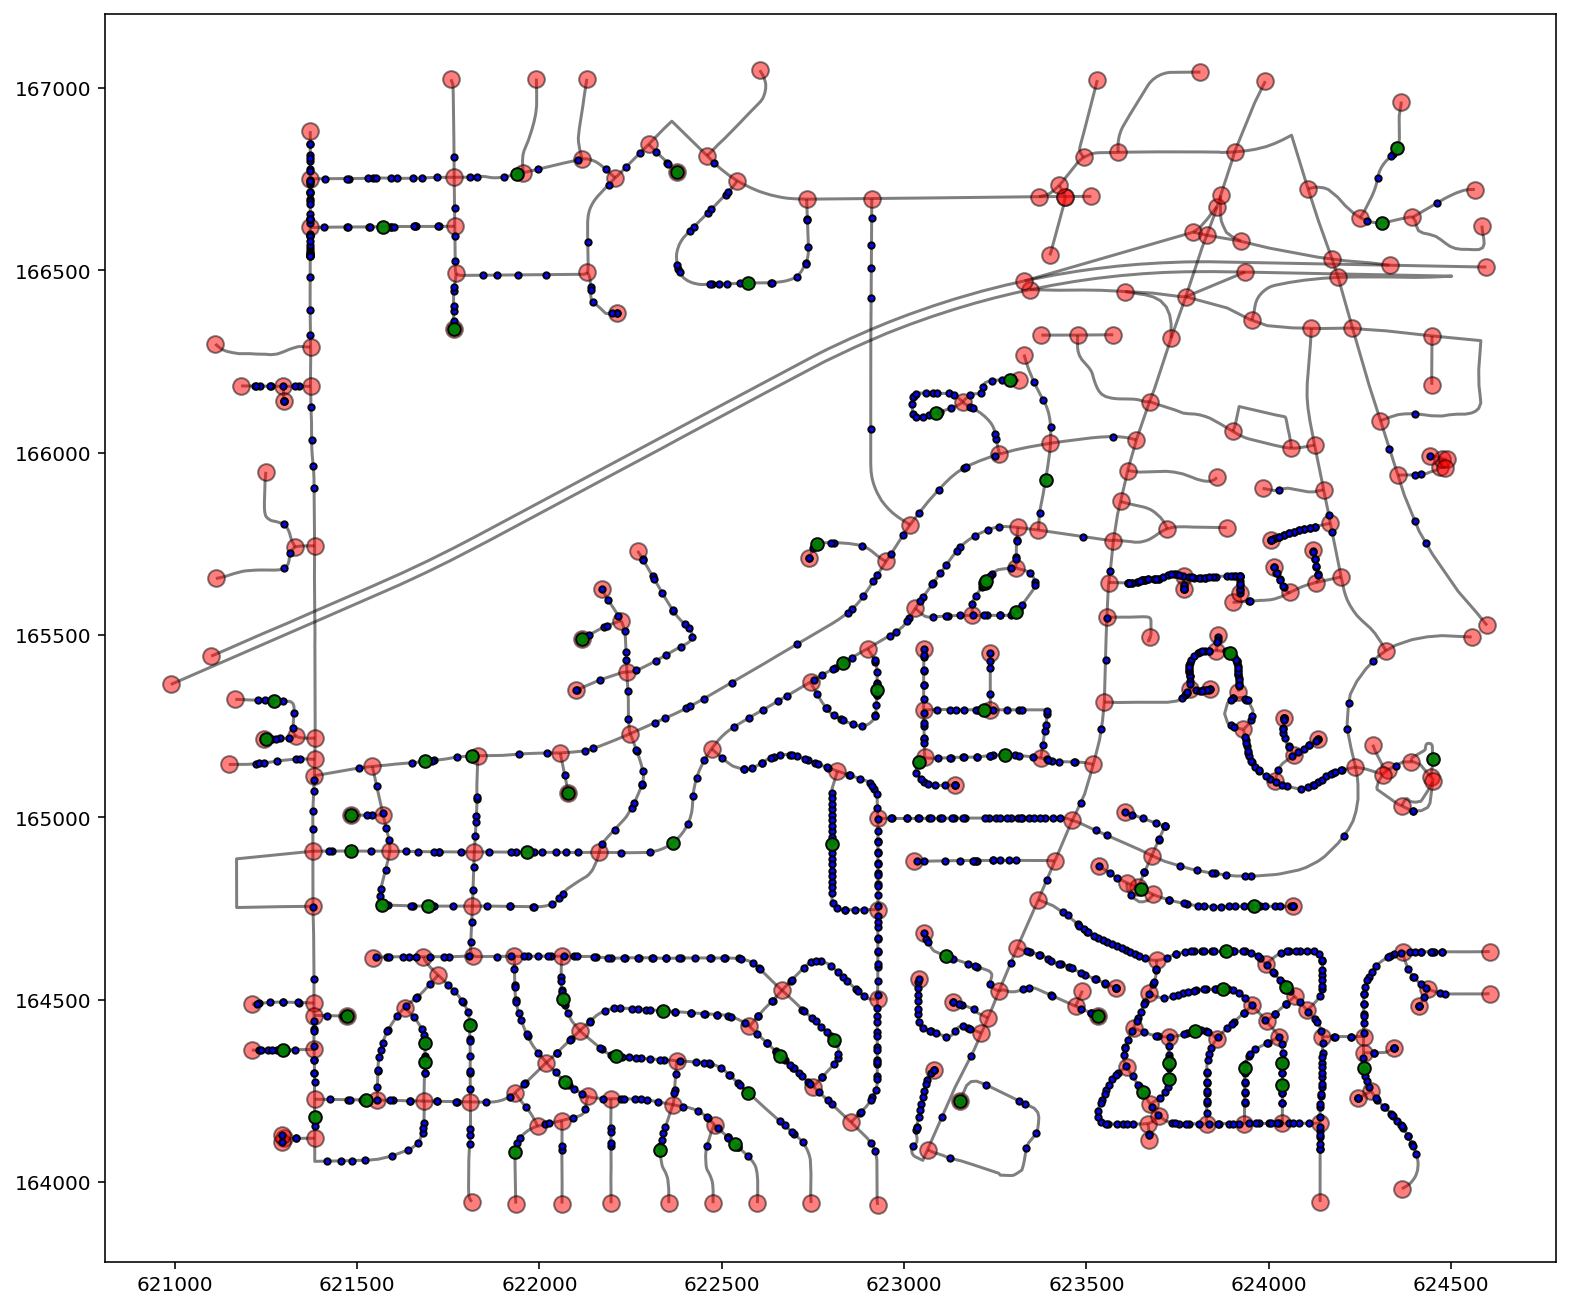

In [16]:
ax = network.s_data.plot(figsize=(13,13), **skws)
network.n_data.plot(ax=ax, **nkws);
parcels.snapped_points.plot(ax=ax, **b1kws)
blocks.snapped_points.plot(ax=ax, **b2kws);

-------------------------------------------------------------
## Generate a cost matrix between all observations

In [17]:
observations_cost_matrix = tigernet.obs2obs_cost_matrix(
    parcels, network, destination_observations=blocks
)
observations_cost_matrix[:4, :4]

array([[2490.37823338, 3124.12783575, 2376.79864032, 2381.66780607],
       [2253.15528259, 2678.99286711, 5183.60059472, 5188.46976047],
       [2958.04412157, 3383.88170609, 4992.12351146, 4996.99267721],
       [3275.33168139, 3909.08128377, 2043.07313812, 2047.94230387]])

In [18]:
observations_cost_matrix.shape

(1592, 67)

In [19]:
len(parcels.obs2segm), len(blocks.obs2segm)

(1592, 67)

------------------------------